In [14]:
# Image type matrix completion
# Loss fixed pionts
import enum
from MinPy import demo, loss, net, reg
import torch
from MinPy.toolbox import dataloader, plot, pprint
import numpy as np

class MissMode(enum.Enum):
    RANDOM = enum.auto() # Random pixels are set to zero
    PATCH = enum.auto() # Entire pixel blocks are set to zero
    FIXED = enum.auto() # A mask from a file is used to determine with pixels are set to zero

class Algorithm(enum.Enum):
    DMF = enum.auto()
    DMF_AIR = enum.auto()

HEIGHT = 240
WIDTH = 240
EPOCHS = 10_001
np.random.seed(20210909)

def drive(miss_mode, image_path, mask_path):
    pic = dataloader.get_data(height=HEIGHT,width=WIDTH,pic_name=image_path).cuda() # Read grayscale image

    plot.gray_im(pic.cpu()) # Display grayscale image

    transformer = dataloader.data_transform(z=pic,return_type='tensor')

    if miss_mode is MissMode.RANDOM:
        mask_in = transformer.get_drop_mask(rate=0.3) # 'rate' is the loss rate
        mask_in[mask_in < 1] = 0
    elif miss_mode is MissMode.PATCH:
        mask_in = torch.ones(HEIGHT, WIDTH).cuda()
        mask_in[70:100, 150:190] = 0
        mask_in[200:230, 200:230] = 0
    elif miss_mode is MissMode.FIXED:
        mask_in = dataloader.get_data(height=HEIGHT, width=WIDTH, pic_name=mask_path)
        mask_in[mask_in < 1] = 0
    else:
        raise ValueError(f'Invalid MissMode: {miss_mode.name}')

    plot.gray_im(pic.cpu() * mask_in.cpu())

    line_dict={'x_plot': np.arange(0, EPOCHS, 1)}
    for algo in [Algorithm.DMF, Algorithm.DMF_AIR]:
        reg_hc = reg.hc_reg(name='lap')
        reg_row = reg.auto_reg(HEIGHT, 'row')
        reg_col = reg.auto_reg(WIDTH, 'col')
        reg_cnn = reg.cnn_reg()
        dmf = demo.basic_dmf([HEIGHT, HEIGHT, HEIGHT, WIDTH], [reg_hc, reg_row, reg_col, reg_cnn]) # Define model

        eta = [None] * 4 if algo is Algorithm.DMF else [None, 1e-4, 1e-4, None]

        #Training model
        for ite in range(EPOCHS):
            dmf.train(pic, mu=1, eta=eta, mask_in=mask_in)

            if ite % 100 == 0:
                pprint.progress_bar(ite, EPOCHS, dmf.loss_dict) # Format the loss of the output training and print out the training progress bar

            if ite % 5000 == 0:
                plot.gray_im(dmf.net.data.cpu().detach().numpy()) # Display the training image, you can set parameters to save the image
                print('RMSE:', torch.sqrt(torch.mean((pic-dmf.net.data)**2)).detach().cpu().numpy())
                #plot.gray_im(dmf.net.show_img().cpu().detach().numpy()) # Display the training image, you can set parameters to save the image

        # save loss values for plotting
        plot_keys_ignore = {'loss_all', 'loss_fid', 'loss_auto_reg_col', 'loss_auto_reg_row'}
        for k, v in dmf.loss_dict.items():
            if k not in plot_keys_ignore and v:
                line_dict[algo.name] = np.array(v)


    plot.lines(line_dict, save_if=False, black_if=True, ylabel_name='NMAE')

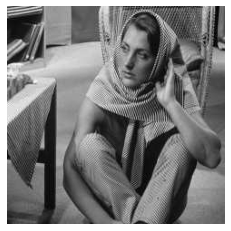

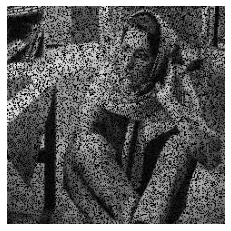

loss_fid:0.16,nmae_test:0.43, loss_all:0.16. Trainning progress: 0.0 %:  

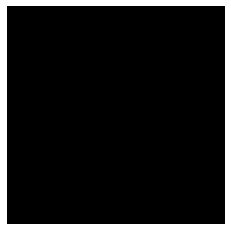

RMSE: 0.47833452
loss_fid:0.00064,nmae_test:0.074, loss_all:0.00064. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

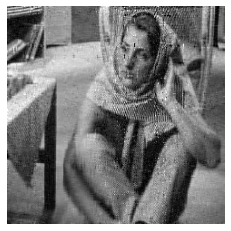

RMSE: 0.065985695
loss_fid:1.7e-05,nmae_test:0.13, loss_all:1.7e-05. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

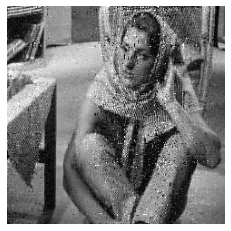

RMSE: 0.10808117
loss_fid:0.16,nmae_test:0.43, loss_all:0.16. Trainning progress: 0.0 %:  

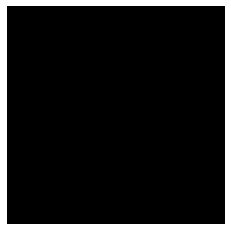

RMSE: 0.4783361
loss_fid:0.011,nmae_test:0.11, loss_all:0.015. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

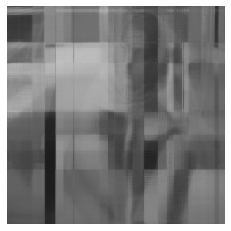

RMSE: 0.12915166
loss_fid:0.00048,nmae_test:0.047, loss_all:0.0012. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

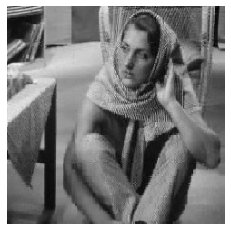

RMSE: 0.046076506


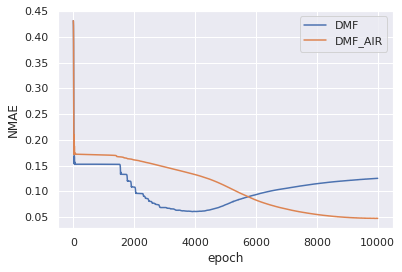

In [15]:
drive(MissMode.RANDOM, './train_pics/Barbara.jpg', './masks/mask.png')

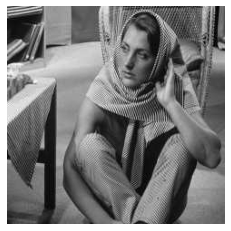

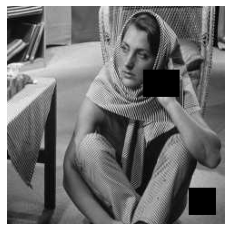

loss_fid:0.22,nmae_test:0.43, loss_all:0.22. Trainning progress: 0.0 %:  

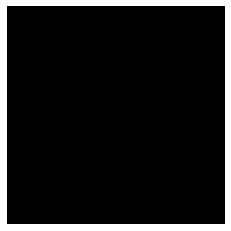

RMSE: 0.4783331
loss_fid:0.0015,nmae_test:0.39, loss_all:0.0015. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

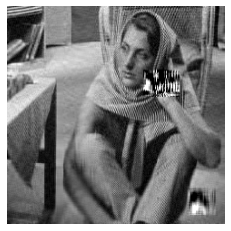

RMSE: 0.10784427
loss_fid:9.4e-05,nmae_test:0.74, loss_all:9.4e-05. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

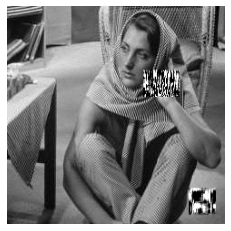

RMSE: 0.19012024
loss_fid:0.22,nmae_test:0.43, loss_all:0.22. Trainning progress: 0.0 %:  

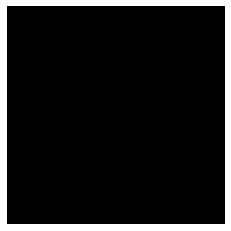

RMSE: 0.47833106
loss_fid:0.01,nmae_test:0.14, loss_all:0.016. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

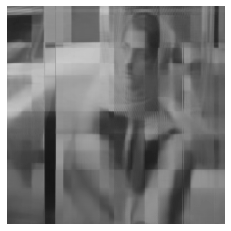

RMSE: 0.10666221
loss_fid:0.00045,nmae_test:0.12, loss_all:0.0011. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

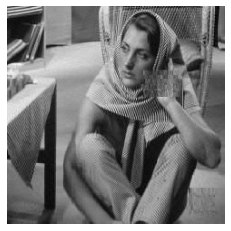

RMSE: 0.036475033


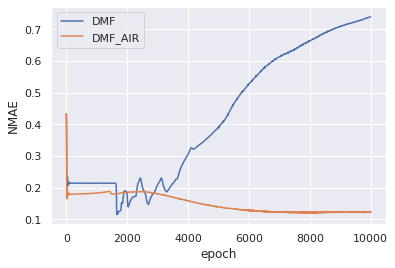

In [17]:
drive(MissMode.PATCH, './train_pics/Barbara.jpg', './masks/mask.png')

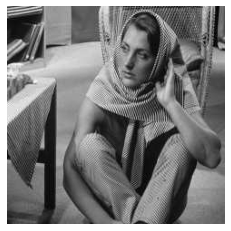

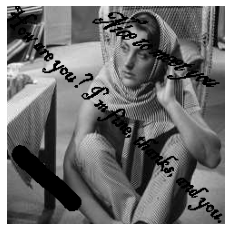

loss_fid:0.21,nmae_test:0.39, loss_all:0.21. Trainning progress: 0.0 %:  

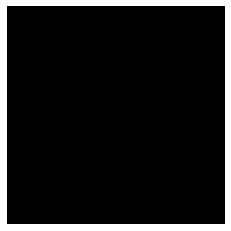

RMSE: 0.47833306
loss_fid:0.0013,nmae_test:0.19, loss_all:0.0013. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

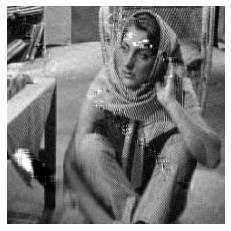

RMSE: 0.104465306
loss_fid:5.9e-05,nmae_test:0.38, loss_all:5.9e-05. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

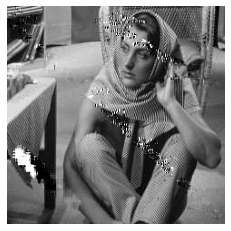

RMSE: 0.21463026
loss_fid:0.21,nmae_test:0.39, loss_all:0.21. Trainning progress: 0.0 %:  

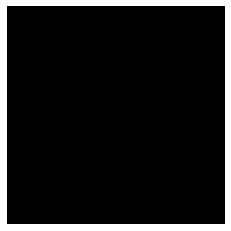

RMSE: 0.4783339
loss_fid:0.01,nmae_test:0.12, loss_all:0.015. Trainning progress: 50.0 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

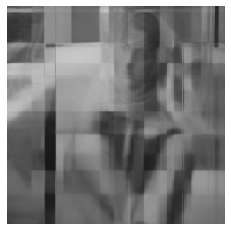

RMSE: 0.11012201
loss_fid:0.00042,nmae_test:0.071, loss_all:0.001. Trainning progress: 1e+02 %:  ▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋▋

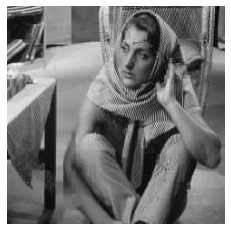

RMSE: 0.037265874


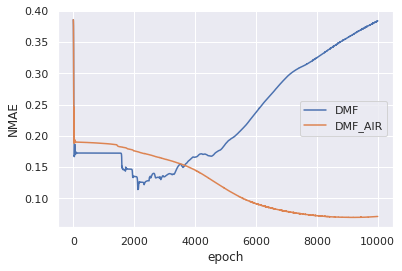

In [18]:
drive(MissMode.FIXED, './train_pics/Barbara.jpg', './masks/mask.png')